# Healthcare analysis

- **``문제 정의`` : 입원하는 환자들의 개인의 특성을 기반으로 해 해당 입원한자의 재원일수(LOS = Length Of Stay) 기간을 예측**
- **``문제 필요성`` : Covid-19 때문에 많은 입원환자 발생으로 인해 병상회전율을 최적화해야 함. 또한 개인 환자의 재원일수 기간을 예측함으로써 해당 환자에게 최적화된 치료법과 의료진과 병원 방문객들의 집단 감염을 막기 위함**

- 데이터 출처 : <a href='https://www.kaggle.com/nehaprabhavalkar/av-healthcare-analytics-ii?'>Kaggle Healthcare analytics</a>
- 데이터 구성
    * train_data.csv
        - 환자, 병원관련 독립변수와 종속변수인 재원일수 포함
    * test_data.csv
        - 환자, 병원관련 독립변수만 포함
    * train_data_dictionary.csv
        - 환자, 병원관련 독립변수에 대한 설명

## 데이터 로드

In [1]:
import os
os.chdir('/Users/younghun/Desktop/gitrepo/data/healthcare')

In [2]:
import pandas as pd
import numpy as np

train = pd.read_csv('train_data.csv')
test = pd.read_csv('test_data.csv')
description = pd.read_csv('train_data_dictionary.csv')

# 각 데이터 shape
print("Train 데이터: ", train.shape)
print("Test 데이터: ", test.shape)
print("Feature Description 데이터: ", description.shape)

Train 데이터:  (318438, 18)
Test 데이터:  (137057, 17)
Feature Description 데이터:  (18, 2)


In [3]:
# 독립변수들 살펴보기
train.columns

Index(['case_id', 'Hospital_code', 'Hospital_type_code', 'City_Code_Hospital',
       'Hospital_region_code', 'Available Extra Rooms in Hospital',
       'Department', 'Ward_Type', 'Ward_Facility_Code', 'Bed Grade',
       'patientid', 'City_Code_Patient', 'Type of Admission',
       'Severity of Illness', 'Visitors with Patient', 'Age',
       'Admission_Deposit', 'Stay'],
      dtype='object')

## 독립변수에 대한 설명

In [4]:
pd.options.display.max_colwidth = 100
description

,Column,Description
0,case_id,Case_ID registered in Hospital
1,Hospital_code,Unique code for the Hospital
2,Hospital_type_code,Unique code for the type of Hospital
3,City_Code_Hospital,City Code of the Hospital
4,Hospital_region_code,Region Code of the Hospital
5,Available Extra Rooms in Hospital,Number of Extra rooms available in the Hospital
6,Department,Department overlooking the case
7,Ward_Type,Code for the Ward type
8,Ward_Facility_Code,Code for the Ward Facility
9,Bed Grade,Condition of Bed in the Ward


<b>**변수들의 유니크한 값들과 개수를 간략하게 살펴봄으로써 어떤 변수인지 파악**</b><br><br>
<b><font size=5> 독립변수 </font></b>
- case_id : 병원에 등록된 입원 id(**테이블에서 unique한 key 성격을 갖음**) => 명목형 변수
- Hospital_code : 병원의 id(unique한 값 32개) => 명목형 변수
- Hospital_type_code : 병원 유형의 id(7가지 범주값) => 명목형 변수
- City_Code_Hospital : 병원이 위치해 있는 도시의 id(11가지 범주값) => 명목형 변수
- Hospital_region_code : 병원이 위치한 지역의 id(3가지 범주값) => 명목형 변수
- Available Extra Rooms in Hospital : 병원에 이용가능한 여분의 병실 수 => 수치형 변수
- Department : 해당 입원을 관리하고 있는 부서(이를 통해 해당 환자의 질병 종류 추측 가능) => 명목형 변수
- Ward_Type : 병실 유형 => ``명목인지 서열인지 파악 필요``
- Ward_Facility_Code : 병실 시설 코드 => ``명목인지 서열인지 파악 필요``
- Bed Grade : 침실 등급 => 서열(Ordinal) 변수
- patientid : 입원 환자의 id(**테이블에서 unqiue하지 않음**)=> 명목형 변수
- City_Code_Patient : 환자가 거주하고 있는 도시 id => 명목형 변수
- Type of Admission : 입원 유형 => ``명목인지 서열인지 파악 필요``
- Severity of Illness : 입원 당일날 기록된 질병의 심각성 => 서열(Ordinal) 변수
- Visitors with Patient : 환자와 동반된 방문객 수 => 수치형 변수
- Age : 환자의 연령 => 범주형 변수(범위화 되어 있음)
- Admission_Deposit : 입원 당일날 결제한 보증금 => 수치형 변수
    * 보증금 : 환자 당사자 또는 환자 당사자와 관련된 방문객이 병원시설을 훼손하거나 하는 경우 등 경제적 손해를 입힐 경우 결제한 보증금에서 공제<br>
    
<b><font size=5> 종속변수 </font></b>
- **Stay(종속변수) : 환자의 재원일수 => level=11인 범주형 변수(범위화 되어 있음)**

---

## 가설 설정(중요도 순서로 재배열하기)<br>

<font size=4>**EDA Agenda**</font>

- 병원 유형id, 병원 위치 도시id, 지역 id에 따라 재원기간 수 차이를 보일 것이다.
- 병원에서 이용가능한 여분의 병실 수가 적을수록 재원기간 수는 짧을 것이다.
- 입원 환자의 질병에 따라 재원기간 수가 유의미한 차이를 보일 것이다.
    * 이 때, 입원 환자의 질병 종류는 해당 입원을 관리하고 있는 부서 종류로 추측 가능
- 침실 등급에 따라 재원 기간 수가 유의미한 차이를 보일 것이다.
- 환자 입원 유형과 입원 당일 질병의 심각성 간의 관계를 살펴보고 이 변수들과 재원기간 수와 관계가 있는지 살펴보기
- 환자 연령이 높을수록 재원기간 수가 길 것이다.
- 보증금 금액이 클수록 재원기간 수가 길 것이다.
    * 보증금 긍액이 크다는 것은 그만큼 병원에 입원하는 재원기간이 길어서 그렇지 않을까?
- 기타 탐색해볼 것
    * 병실 유형과 시설 id에 따라 재원기간 수 차이
    * 환자 거주 도시 id에 따라 재원기간 수 차이
    * 환자와 동반된 방문객 수에 따라 재원기간 수 차이

### 첫 번째 가설

- ``병원 유형 code, 병원 위치 도시 code, 병원 위치 지역 code에 따라 재원기간 수 차이를 보일 것이다.``
- 병원 유형별(ex.종합병원, 상급종합병원 등) 또는 지역별로 병원의 크기가 다를 것이기 때문에 이는 결국 병상의 개수에도 직접적으로 연결된다. 병상의 개수가 많을수록 병상의 개수는 많을 것이며 이는 결국 재원일수와도 관련될 것이다.

In [8]:
# 관련있는 변수들만 추출
# 병원 유형 code, 병원 위치 도시 code, 지역 code, 여분 병실 수, 연령, 재원일수(종속변수) 만 추출
cols = ['Hospital_type_code','City_Code_Hospital','Hospital_region_code',
       'Available Extra Rooms in Hospital', 'Age', 'Stay']
hospital_df = train[cols]
hospital_df.shape

(318438, 6)

In [15]:
# 범주형 변수별 unique한 값들 살펴보기
cols = ['Hospital_type_code','City_Code_Hospital','Hospital_region_code', 'Age', 'Stay']
for col in cols:
    unique_val = hospital_df[col].unique()
    nunique_val = hospital_df[col].nunique()
    print(f"{col} 변수의 unique한 값 종류 개수:{nunique_val}\n{col} 변수의 unique한 값 종류들:\n{unique_val}")
    print('-'*40)

Hospital_type_code 변수의 unique한 값 종류 개수:7
Hospital_type_code 변수의 unique한 값 종류들:
['c' 'e' 'b' 'a' 'f' 'd' 'g']
----------------------------------------
City_Code_Hospital 변수의 unique한 값 종류 개수:11
City_Code_Hospital 변수의 unique한 값 종류들:
[ 3  5  1  2  6  9 10  4 11  7 13]
----------------------------------------
Hospital_region_code 변수의 unique한 값 종류 개수:3
Hospital_region_code 변수의 unique한 값 종류들:
['Z' 'X' 'Y']
----------------------------------------
Age 변수의 unique한 값 종류 개수:10
Age 변수의 unique한 값 종류들:
['51-60' '71-80' '31-40' '41-50' '81-90' '61-70' '21-30' '11-20' '0-10'
 '91-100']
----------------------------------------
Stay 변수의 unique한 값 종류 개수:11
Stay 변수의 unique한 값 종류들:
['0-10' '41-50' '31-40' '11-20' '51-60' '21-30' '71-80'
 'More than 100 Days' '81-90' '61-70' '91-100']
----------------------------------------


In [13]:
# 추출한 변수들 결측치 확인
hospital_df.isnull().sum()

Hospital_type_code                   0
City_Code_Hospital                   0
Hospital_region_code                 0
Available Extra Rooms in Hospital    0
Age                                  0
Stay                                 0
dtype: int64

In [14]:
#수치형 변수이어야 하는데 범주형 type으로 되어 있으며 whitespace로 결측치가 되어있을 수도 있으니 변수별 dtype 체크
hospital_df.dtypes

Hospital_type_code                   object
City_Code_Hospital                    int64
Hospital_region_code                 object
Available Extra Rooms in Hospital     int64
Age                                  object
Stay                                 object
dtype: object

- Age, Stay는 범위(range)화 되어 있어서 범주형 변수인게 맞음

---

#### 병원 유형 코드와 여분 병실 수치를 이용해 병원 유형 추론해보기

- 현재 병원 유형 코드가 익명화 되어 있는 상태. 따라서 아래와 같은 내용을 기반으로 병원의 크기를 추론해보자.
- 우선 병원 유형별로 입원환자들이 얼마나 많았는지 살펴보고 이를 활용해 여분 병실 수를 비율로 나타내보기
- 예를들어, 10명이 입원한 병원의 여분 병실수가 100개인 A병원과 1000명이 입원한 병원의 여분 병실수가 100개인 B병원 둘 중 병상회전율이 좋은 당연히 B병원일 것이다. 이를 알아보기 위한 분석 수행  
- 따라서 공식은 ``'(입원환자 수 / 여분 병실수) * 100'`` 을 이용. ``이 값이 높을수록 병원의 병상회전율이 클 것``이다.
- 단, 병상회전율 공식을 사용하기엔 입원, 퇴원 환자수와 정확한 재원일수를 알아야 하는데 알 수 없음. 따라서 임의적으로 공식을 만듦..(한계점)

In [34]:
hospital_code_count = hospital_df.groupby(['Hospital_type_code']).agg({'Hospital_type_code':'count'}).rename(columns={'Hospital_type_code':'count'})
hospital_code_count

,count
Hospital_type_code,
a,143425
b,68946
c,45928
d,20389
e,24770
f,10703
g,4277


In [35]:
type_sum_df = hospital_df.groupby('Hospital_type_code').agg({'Available Extra Rooms in Hospital':'sum'}).rename(columns={'Available Extra Rooms in Hospital':'sum'})
type_sum_df

,sum
Hospital_type_code,
a,468336
b,224631
c,145676
d,65173
e,74450
f,28274
g,11706


In [39]:
# 위 두 데이터프레임 concat 하기
concat_df = pd.concat([hospital_code_count, type_sum_df], axis=1)
concat_df['ratio'] = (concat_df['count'] / concat_df['sum']) * 100
concat_df = concat_df.sort_values(by='ratio', ascending=False)
concat_df

,count,sum,ratio
Hospital_type_code,,,
f,10703,28274,37.854566
g,4277,11706,36.536819
e,24770,74450,33.270651
c,45928,145676,31.527499
d,20389,65173,31.284428
b,68946,224631,30.693003
a,143425,468336,30.624381


- 결과 해석하기가 애매모호..
---

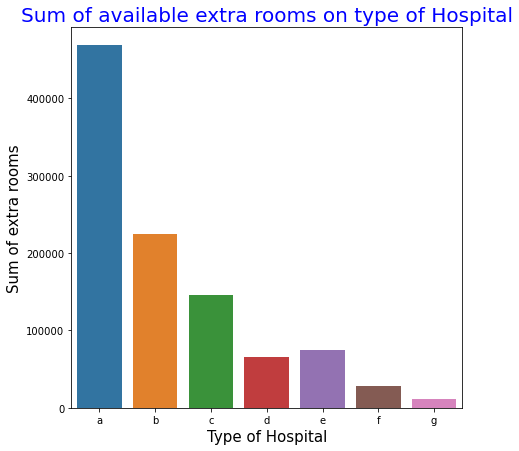

In [24]:
import matplotlib.pyplot as plt
import seaborn as sns

type_sum_df = hospital_df.groupby('Hospital_type_code').agg({'Available Extra Rooms in Hospital':'sum'}).rename(columns={'Available Extra Rooms in Hospital':'sum'})

plt.figure(figsize=(7,7))
sns.barplot(data=type_sum_df, x=type_sum_df.index, y='sum')
plt.title('Sum of available extra rooms on type of Hospital', fontsize=20, color='blue')
plt.xlabel('Type of Hospital', fontsize=15)
plt.ylabel('Sum ofextra rooms', fontsize=15)
plt.show()

- a병원이 압도적으로 여분의 병실이 많았다. 대체 ``a병원은 어디지역에 위치해 있는지 확인해보자.``
- ``b,c 병원의 위치 파악하기``
- ``d,e,f,g 병원의 위치 파악하기``

#### 병원들 유형에 따라 병원이 어떤 지역과 도시에 위치해있는지 살펴보기

In [47]:
# 위치 지역(region) 파악
region_df = hospital_df.groupby(['Hospital_type_code','Hospital_region_code']).agg({'Hospital_type_code':'count'}).rename(columns={'Hospital_type_code':'count'})
region_df = region_df.reset_index()
region_df



,Hospital_type_code,Hospital_region_code,count
0,a,X,91429
1,a,Y,46760
2,a,Z,5236
3,b,X,17137
4,b,Y,51809
5,c,Z,45928
6,d,Y,8879
7,d,Z,11510
8,e,X,24770
9,f,Y,10703


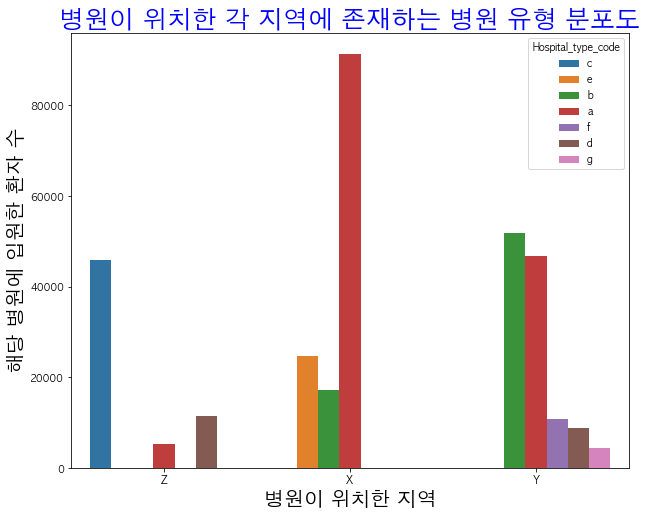

In [60]:
plt.rc('font', family='AppleGothic')
plt.figure(figsize=(10,8))
sns.countplot(data=hospital_df, x='Hospital_region_code', hue='Hospital_type_code')
plt.title("병원이 위치한 각 지역에 존재하는 병원 유형 분포도", fontsize=25, color='blue')
plt.xlabel('병원이 위치한 지역', fontsize=20)
plt.ylabel('해당 병원에 입원한 환자 수', fontsize=20)
plt.show()

- X라는 지역에는
    * a라는 유형의 병원에 입원한 환자가 압도적으로 가장 많으며 적은 입원환자 숫자를 기록했지만 b, e 유형의 병원에도 입원
- Y라는 지역에는
    * a,b 유형의 병원에 입원환자 대부분이 입원했으며 소수의 환자들은 f,d,g 유형의 병원에 입원
- Z라는 지역에는
    * c라는 유형의 병원에 입원환자 대부분이 입원했으며 소수의 환자들은 a, d 유형의 병원에 입원<br><br>
    
- 따라서,
    * **X지역**에는 a 유형의 병원이 많이 존재하며 b, e 유형의 병원은 소수 존재
    * **Y지역**에는 a,b 유형의 병원이 대부분 존재하며, f,d,g 유형의 병원은 소수 존재
    * **Z지역**에는 c 유형의 병원이 대부분 존재하며, a, d 유형의 병원이 소수 존재

In [ ]:
# 방향설 잘 잡기
# 우선 변수별로 stay 빈도수 카이제곱 검정하고 다르다는 거 확인되면 그 다음 위와 같이 자세한 EDA 실행하기

,Hospital_type_code,City_Code_Hospital,Hospital_region_code,Available Extra Rooms in Hospital,Age,Stay
0,c,3,Z,3,51-60,0-10
1,c,5,Z,2,51-60,41-50
2,e,1,X,2,51-60,31-40
3,b,2,Y,2,51-60,41-50
4,b,2,Y,2,51-60,41-50
